In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('data/data.csv')

initial_time = float(list(data.columns)[0])

# Renaming columns
previous_columns = list(data.columns)
new_columns = ['time', 'bid_price','ask_price', 'bid_volume_0', 'bid_volume_1', 'bid_volume_2', 'bid_volume_3', 'bid_volume_4', 'ask_volume_0', 'ask_volume_1', 'ask_volume_2', 'ask_volume_3', 'ask_volume_4']
columns_dict = dict(zip(previous_columns, new_columns))
data = data.rename(columns=columns_dict)

# Adjusting initial time
data['time'] = data['time'] - initial_time

# Generating sprad and mid_price
data['mid_price'] = (data['ask_price'] + data['bid_price']) / 2
data['spread'] = data['ask_price'] - data['bid_price']

# Getting rid of bid and ask price columns
data = data.drop(columns=['bid_price', 'ask_price', 'time'])

In [3]:
data

,bid_volume_0,bid_volume_1,bid_volume_2,bid_volume_3,bid_volume_4,ask_volume_0,ask_volume_1,ask_volume_2,ask_volume_3,ask_volume_4,mid_price,spread
0,55,30,45,25,10000,34,30,10035,0,0,126300.0,200
1,55,30,45,25,10000,34,30,10035,0,0,126300.0,200
2,25,140,75,45,25,85,35,10,10000,0,126650.0,100
3,25,185,75,10045,25,85,65,10,10000,0,126650.0,100
4,25,85,110,65,10045,65,65,30,35,10000,126650.0,100
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,74,32,55,10000,113,109,80,101,10079,2,125150.0,300
3596,104,32,55,10000,113,109,80,101,10079,2,125150.0,300
3597,104,92,35,20,113,99,10101,79,2,88,125200.0,400
3598,48,32,66,55,113,109,10,20,10101,79,125100.0,200


In [4]:
SHIFTS = [1,3,7,14,28,56]

In [111]:
type(np.array(data)) == np.ndarray

True

In [112]:
data.tail(4000  )

,bid_volume_0,bid_volume_1,bid_volume_2,bid_volume_3,bid_volume_4,ask_volume_0,ask_volume_1,ask_volume_2,ask_volume_3,ask_volume_4,mid_price,spread
0,55,30,45,25,10000,34,30,10035,0,0,126300.0,200
1,55,30,45,25,10000,34,30,10035,0,0,126300.0,200
2,25,140,75,45,25,85,35,10,10000,0,126650.0,100
3,25,185,75,10045,25,85,65,10,10000,0,126650.0,100
4,25,85,110,65,10045,65,65,30,35,10000,126650.0,100
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,74,32,55,10000,113,109,80,101,10079,2,125150.0,300
3596,104,32,55,10000,113,109,80,101,10079,2,125150.0,300
3597,104,92,35,20,113,99,10101,79,2,88,125200.0,400
3598,48,32,66,55,113,109,10,20,10101,79,125100.0,200


# Creating features

## Momentum features

In [6]:
data.iloc[55:]['mid_price']

55      127650.0
56      127600.0
57      127600.0
58      127450.0
59      127500.0
          ...   
3595    125150.0
3596    125150.0
3597    125200.0
3598    125100.0
3599    125150.0
Name: mid_price, Length: 3545, dtype: float64

In [7]:
def create_return_features(data : pd.DataFrame, shifts : list) -> pd.DataFrame:
    '''
    Takes the raw dataframe (data) with the day shifts we want to compute returns (shifts).
    Return the dataframe with the new features.
    '''
    new_data = data.copy()

    for day in shifts:
        new_data[f'returns_{day}'] = data['mid_price'].div(data['mid_price'].shift(day)) - 1
        
        if day != 1:
            new_data[f'return_average_price_{day}'] = data['mid_price'].div(data['mid_price'].rolling(day).mean()) - 1

    return new_data.dropna(axis = 0)

In [8]:
def create_variable_next_day_price(data : pd.DataFrame) -> pd.DataFrame:
    '''
    Takes raw dataframe and adds a new column with the price on the next day
    '''
    new_data = data.copy()
    new_data['target'] = (data['mid_price'].shift(-1) - data['mid_price'])/data['mid_price']
    new_data.drop(columns='mid_price')

    return new_data.dropna(axis = 0)

In [9]:
def create_complete_data(data : pd.DataFrame, shifts : list) -> pd.DataFrame:
    '''
    Takes raw dataframe and generate the dataframe with new features and next day price
    '''
    new_data = data.copy()
    new_data = create_return_features(data, shifts)
    new_data = create_variable_next_day_price(new_data)

    return new_data

In [10]:
data_new = create_complete_data(data, SHIFTS)

In [11]:
data_new

,bid_volume_0,bid_volume_1,bid_volume_2,bid_volume_3,bid_volume_4,ask_volume_0,ask_volume_1,ask_volume_2,ask_volume_3,ask_volume_4,...,return_average_price_3,returns_7,return_average_price_7,returns_14,return_average_price_14,returns_28,return_average_price_28,returns_56,return_average_price_56,target
56,7,115,98,62,105,68,118,285,35,10027,...,-0.000131,0.000392,-0.000280,0.001570,0.000196,0.000000,0.000266,0.010293,0.001093,0.000000
57,7,115,98,62,105,98,118,285,35,10027,...,-0.000131,-0.000392,-0.000224,0.000784,0.000140,0.000000,0.000266,0.010293,0.000910,-0.001176
58,85,110,62,140,106,13,38,30,118,285,...,-0.000784,-0.001567,-0.001176,-0.000392,-0.001008,-0.000784,-0.000882,0.006317,-0.000378,0.000392
59,5,140,62,140,106,34,30,118,285,10000,...,-0.000131,-0.001175,-0.000616,0.000000,-0.000616,-0.000392,-0.000476,0.006711,-0.000105,0.000392
60,101,25,120,62,10140,22,30,118,285,35,...,0.000392,-0.000783,-0.000112,0.000392,-0.000252,0.000392,-0.000098,0.007106,0.000161,0.000392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,68,68,55,10113,100,20,109,80,101,10000,...,-0.000266,0.000000,-0.000628,-0.003586,-0.001397,-0.003189,-0.002294,0.000400,-0.000820,0.000800
3595,74,32,55,10000,113,109,80,101,10079,2,...,0.000533,0.000000,0.000171,-0.001994,-0.000456,-0.002391,-0.001411,0.000400,-0.000029,0.000000
3596,104,32,55,10000,113,109,80,101,10079,2,...,0.000266,0.000000,0.000171,-0.001994,-0.000314,-0.002391,-0.001325,0.001601,-0.000057,0.000400
3597,104,92,35,20,113,99,10101,79,2,88,...,0.000266,0.000400,0.000514,-0.001993,0.000228,-0.001993,-0.000855,0.002001,0.000307,-0.000799


In [12]:
price_feature_names = ("return")
price_feature_mask = data_new\
    .columns\
    .str\
    .startswith(price_feature_names)

In [13]:
price_features = data_new[data_new.columns[price_feature_mask]]

In [14]:
price_features

,returns_1,returns_3,return_average_price_3,returns_7,return_average_price_7,returns_14,return_average_price_14,returns_28,return_average_price_28,returns_56,return_average_price_56
56,-0.000392,-0.000392,-0.000131,0.000392,-0.000280,0.001570,0.000196,0.000000,0.000266,0.010293,0.001093
57,0.000000,0.000000,-0.000131,-0.000392,-0.000224,0.000784,0.000140,0.000000,0.000266,0.010293,0.000910
58,-0.001176,-0.001567,-0.000784,-0.001567,-0.001176,-0.000392,-0.001008,-0.000784,-0.000882,0.006317,-0.000378
59,0.000392,-0.000784,-0.000131,-0.001175,-0.000616,0.000000,-0.000616,-0.000392,-0.000476,0.006711,-0.000105
60,0.000392,-0.000392,0.000392,-0.000783,-0.000112,0.000392,-0.000252,0.000392,-0.000098,0.007106,0.000161
...,...,...,...,...,...,...,...,...,...,...,...
3594,0.000000,-0.001198,-0.000266,0.000000,-0.000628,-0.003586,-0.001397,-0.003189,-0.002294,0.000400,-0.000820
3595,0.000800,0.000000,0.000533,0.000000,0.000171,-0.001994,-0.000456,-0.002391,-0.001411,0.000400,-0.000029
3596,0.000000,0.000800,0.000266,0.000000,0.000171,-0.001994,-0.000314,-0.002391,-0.001325,0.001601,-0.000057
3597,0.000400,0.001200,0.000266,0.000400,0.000514,-0.001993,0.000228,-0.001993,-0.000855,0.002001,0.000307


In [15]:
target_mask = data_new\
    .columns\
    .str\
    .startswith("target")

In [45]:
y = data_new['target']

In [46]:
y

56      0.000000
57     -0.001176
58      0.000392
59      0.000392
60      0.000392
          ...   
3594    0.000800
3595    0.000000
3596    0.000400
3597   -0.000799
3598    0.000400
Name: target, Length: 3543, dtype: float64

## Generate 10k position bid and ask features

In [18]:
bid_mask = data\
    .columns\
    .str\
    .contains("bid", )

bid_df = data[data.columns[bid_mask]]

In [19]:
bid_df 

,bid_volume_0,bid_volume_1,bid_volume_2,bid_volume_3,bid_volume_4
0,55,30,45,25,10000
1,55,30,45,25,10000
2,25,140,75,45,25
3,25,185,75,10045,25
4,25,85,110,65,10045
...,...,...,...,...,...
3595,74,32,55,10000,113
3596,104,32,55,10000,113
3597,104,92,35,20,113
3598,48,32,66,55,113


In [20]:
bid_volume_feature = (bid_df @ np.array([1, 2, 3, 4, 5]) // 9000)\
    .replace(0, 6)

In [21]:
bid_volume_feature

0       5
1       5
2       6
3       4
4       5
       ..
3595    4
3596    4
3597    6
3598    6
3599    5
Length: 3600, dtype: int64

In [22]:
ask_mask = data\
    .columns\
    .str\
    .contains("ask")

ask_df = data[data.columns[ask_mask]]

In [23]:
ask_volume_feature = (ask_df @ np.array([1,2,3,4,5]) // 9000)\
    .replace(0,6)

# Spread 

In [24]:
spread_feature = data['spread']

In [25]:
price_features

,returns_1,returns_3,return_average_price_3,returns_7,return_average_price_7,returns_14,return_average_price_14,returns_28,return_average_price_28,returns_56,return_average_price_56
56,-0.000392,-0.000392,-0.000131,0.000392,-0.000280,0.001570,0.000196,0.000000,0.000266,0.010293,0.001093
57,0.000000,0.000000,-0.000131,-0.000392,-0.000224,0.000784,0.000140,0.000000,0.000266,0.010293,0.000910
58,-0.001176,-0.001567,-0.000784,-0.001567,-0.001176,-0.000392,-0.001008,-0.000784,-0.000882,0.006317,-0.000378
59,0.000392,-0.000784,-0.000131,-0.001175,-0.000616,0.000000,-0.000616,-0.000392,-0.000476,0.006711,-0.000105
60,0.000392,-0.000392,0.000392,-0.000783,-0.000112,0.000392,-0.000252,0.000392,-0.000098,0.007106,0.000161
...,...,...,...,...,...,...,...,...,...,...,...
3594,0.000000,-0.001198,-0.000266,0.000000,-0.000628,-0.003586,-0.001397,-0.003189,-0.002294,0.000400,-0.000820
3595,0.000800,0.000000,0.000533,0.000000,0.000171,-0.001994,-0.000456,-0.002391,-0.001411,0.000400,-0.000029
3596,0.000000,0.000800,0.000266,0.000000,0.000171,-0.001994,-0.000314,-0.002391,-0.001325,0.001601,-0.000057
3597,0.000400,0.001200,0.000266,0.000400,0.000514,-0.001993,0.000228,-0.001993,-0.000855,0.002001,0.000307


In [26]:
price_features

,returns_1,returns_3,return_average_price_3,returns_7,return_average_price_7,returns_14,return_average_price_14,returns_28,return_average_price_28,returns_56,return_average_price_56
56,-0.000392,-0.000392,-0.000131,0.000392,-0.000280,0.001570,0.000196,0.000000,0.000266,0.010293,0.001093
57,0.000000,0.000000,-0.000131,-0.000392,-0.000224,0.000784,0.000140,0.000000,0.000266,0.010293,0.000910
58,-0.001176,-0.001567,-0.000784,-0.001567,-0.001176,-0.000392,-0.001008,-0.000784,-0.000882,0.006317,-0.000378
59,0.000392,-0.000784,-0.000131,-0.001175,-0.000616,0.000000,-0.000616,-0.000392,-0.000476,0.006711,-0.000105
60,0.000392,-0.000392,0.000392,-0.000783,-0.000112,0.000392,-0.000252,0.000392,-0.000098,0.007106,0.000161
...,...,...,...,...,...,...,...,...,...,...,...
3594,0.000000,-0.001198,-0.000266,0.000000,-0.000628,-0.003586,-0.001397,-0.003189,-0.002294,0.000400,-0.000820
3595,0.000800,0.000000,0.000533,0.000000,0.000171,-0.001994,-0.000456,-0.002391,-0.001411,0.000400,-0.000029
3596,0.000000,0.000800,0.000266,0.000000,0.000171,-0.001994,-0.000314,-0.002391,-0.001325,0.001601,-0.000057
3597,0.000400,0.001200,0.000266,0.000400,0.000514,-0.001993,0.000228,-0.001993,-0.000855,0.002001,0.000307


In [27]:
X = price_features.copy()

In [28]:
X['spread'] = spread_feature
X['ask_volume'] = ask_volume_feature
X['bid_volume'] = bid_volume_feature

In [29]:
X

,returns_1,returns_3,return_average_price_3,returns_7,return_average_price_7,returns_14,return_average_price_14,returns_28,return_average_price_28,returns_56,return_average_price_56,spread,ask_volume,bid_volume
56,-0.000392,-0.000392,-0.000131,0.000392,-0.000280,0.001570,0.000196,0.000000,0.000266,0.010293,0.001093,200,5,6
57,0.000000,0.000000,-0.000131,-0.000392,-0.000224,0.000784,0.000140,0.000000,0.000266,0.010293,0.000910,200,5,6
58,-0.001176,-0.001567,-0.000784,-0.001567,-0.001176,-0.000392,-0.001008,-0.000784,-0.000882,0.006317,-0.000378,100,6,6
59,0.000392,-0.000784,-0.000131,-0.001175,-0.000616,0.000000,-0.000616,-0.000392,-0.000476,0.006711,-0.000105,200,5,6
60,0.000392,-0.000392,0.000392,-0.000783,-0.000112,0.000392,-0.000252,0.000392,-0.000098,0.007106,0.000161,100,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,0.000000,-0.001198,-0.000266,0.000000,-0.000628,-0.003586,-0.001397,-0.003189,-0.002294,0.000400,-0.000820,100,5,4
3595,0.000800,0.000000,0.000533,0.000000,0.000171,-0.001994,-0.000456,-0.002391,-0.001411,0.000400,-0.000029,300,4,4
3596,0.000000,0.000800,0.000266,0.000000,0.000171,-0.001994,-0.000314,-0.002391,-0.001325,0.001601,-0.000057,300,4,4
3597,0.000400,0.001200,0.000266,0.000400,0.000514,-0.001993,0.000228,-0.001993,-0.000855,0.002001,0.000307,400,2,6


In [80]:
remaining_features = [
    'return_average_price_3',
    'return_average_price_7',
    'return_average_price_56',
    'ask_volume',
    'bid_volume',
    'spread'
]
X_selected = X[remaining_features]

In [81]:
X_selected

,return_average_price_3,return_average_price_7,return_average_price_56,ask_volume,bid_volume,spread
56,-0.000131,-0.000280,0.001093,5,6,200
57,-0.000131,-0.000224,0.000910,5,6,200
58,-0.000784,-0.001176,-0.000378,6,6,100
59,-0.000131,-0.000616,-0.000105,5,6,200
60,0.000392,-0.000112,0.000161,6,5,100
...,...,...,...,...,...,...
3594,-0.000266,-0.000628,-0.000820,5,4,100
3595,0.000533,0.000171,-0.000029,4,4,300
3596,0.000266,0.000171,-0.000057,4,4,300
3597,0.000266,0.000514,0.000307,2,6,400


In [82]:
y

56      0.000000
57     -0.001176
58      0.000392
59      0.000392
60      0.000392
          ...   
3594    0.000800
3595    0.000000
3596    0.000400
3597   -0.000799
3598    0.000400
Name: target, Length: 3543, dtype: float64

# Linear regression

In [83]:
model = LinearRegression()
model.fit(X_selected, y)

LinearRegression()

In [84]:
model.coef_

array([-2.18332858e-01,  9.06367556e-03, -2.67875860e-02,  5.22615116e-05,
       -3.04023592e-05, -1.60608815e-07])

In [85]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, model.predict(X_selected))

7.048157196296178e-07

# Correlation study

In [34]:
def correlation_study_df(data : pd.DataFrame, shifts : list) -> pd.DataFrame:
    '''
    Takes the raw dataframe and time shifts and generate the dataset with all features up to 2009
    for the correlation study
    '''
    
    data_corr = create_complete_data(data, shifts)

    return data_corr.drop(columns=['mid_price'])

In [ ]:
dropping = ['returns_3', 'returns_7', 'returns_14']

In [68]:
remaining_features = [
    'return_average_price_3',
    'return_average_price_7',
    'return_average_price_56',
    'ask_volume',
    'bid_volume',
    'target'
]

<AxesSubplot:>

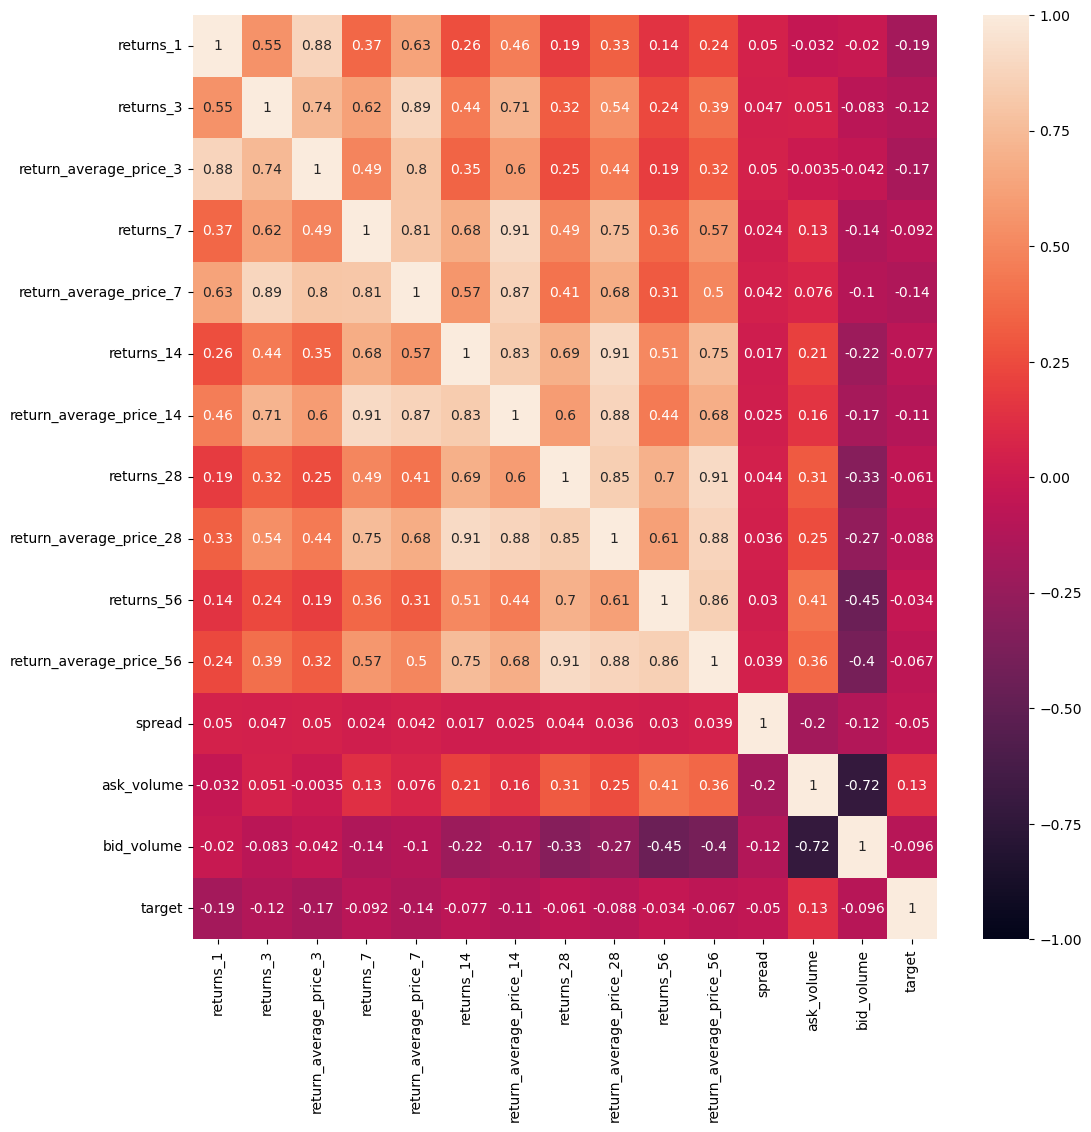

In [64]:
# data_corr = correlation_study_df(data, SHIFTS)

data_corr = X.copy()
data_corr['target'] = y

plt.figure(figsize=(12,12))
sns.heatmap(data = data_corr.corr(), annot=True, vmin = -1, vmax = 1)

<AxesSubplot:>

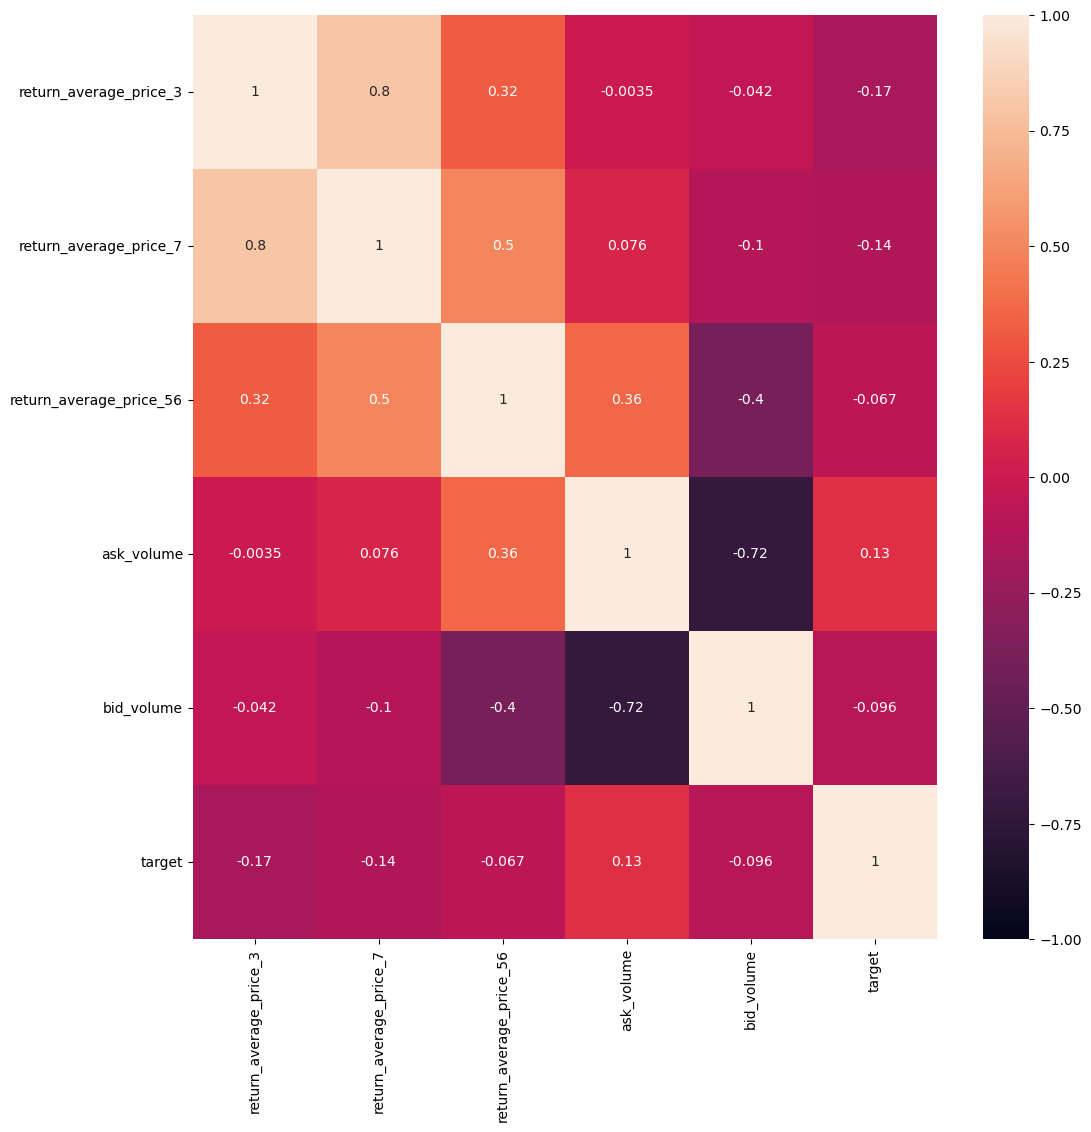

In [69]:
# COLUMNS_TO_DROP = ['returns_1', 'returns_3', 'returns_7','returns_14','return_average_price_14','return_average_price_56','return_average_price_28']

plt.figure(figsize=(12,12))
sns.heatmap(data = data_corr[remaining_features].corr(), annot=True, vmin = -1, vmax = 1)

In [37]:
def create_complete_data_without_corr_columns(data : pd.DataFrame, shifts : list, columns_to_drop) -> pd.DataFrame:
    '''
    Takes raw dataframe and generate the dataframe with new features and next day price without the highly correlated columns
    '''
    new_data = data.copy()
    new_data = create_return_features(data, shifts)
    new_data = create_variable_next_day_price(new_data)
    new_data = new_data.drop(columns = ['next_day_price'])

    return new_data.drop(columns = columns_to_drop)

# Main function

In [39]:
def get_prices_features(data: pd.DataFrame):
    
    price_feature_names = ("return")
    price_feature_mask = data\
        .columns\
        .str\
        .startswith(price_feature_names)
    
    return data[data.columns[price_feature_mask]]

In [40]:
def get_volume_features(data: pd.DataFrame):
    bid_mask = data\
        .columns\
        .str\
        .contains("bid")
    
    bid_df = data[data.columns[bid_mask]]
    bid_volume_feature = (bid_df @ np.array([1,2,3,4,5])//9000)\
        .replace(0,6)
    
    ask_mask = data\
        .columns\
        .str\
        .contains("ask")

    ask_df = data[data.columns[ask_mask]]

    ask_volume_feature = (ask_df @ np.array([1,2,3,4,5]) // 9000)\
        .replace(0,6)
    
    return bid_volume_feature, ask_volume_feature

In [41]:
def transform(data : pd.DataFrame):
    SHIFTS = [1,3,7,14,28,56]

    data_new = create_complete_data(data, SHIFTS)
    price_features = get_prices_features(data_new)
    bid_volume_feature, ask_volume_feature = get_volume_features(data_new)
    spread_feature = data_new['spread']

    X = price_features.copy()
    X['spread'] = spread_feature
    X['ask_volume'] = ask_volume_feature
    X['bid_volume'] = bid_volume_feature
    
    y = data_new['target']

    return X, y

# Testing

2

In [87]:
data.columns

Index(['bid_volume_0', 'bid_volume_1', 'bid_volume_2', 'bid_volume_3',
       'bid_volume_4', 'ask_volume_0', 'ask_volume_1', 'ask_volume_2',
       'ask_volume_3', 'ask_volume_4', 'mid_price', 'spread'],
      dtype='object')

In [42]:
X_, y_ = transform(data)

In [43]:
pd.DataFrame.equals(X, X_)

True

In [47]:
pd.DataFrame.equals(y, y_)

True

In [48]:
from features.make_dataset import transform

In [49]:
X__, y__ = transform(data)

In [51]:
pd.DataFrame.equals(X__, X)

True

In [53]:
pd.DataFrame.equals(y__, y)

True

In [98]:
arr = pd.DataFrame({'a':[1,2,3]})
b = pd.DataFrame([4,5,6])

In [101]:
arr

,a
0,1
1,2
2,3


In [96]:
pd.concat([arr, b.T], axis=1)

,0,0,1,2
0,1,4.0,5.0,6.0
1,2,NaN,NaN,NaN
2,3,NaN,NaN,NaN
